# What's My Flight Status?
***
Author: Andre Layton
***



## Overview
Notes: Construct like an abstract - summary of my entire analysis: 
mention dataset sources, my workflow steps and process, results, evaluations, and conclusions drawn!

## Business Problem

The *Wall Street Journal* recently released their annual airline rankings report, where United Airlines dropped out of the top five. Now at \#6, due to a variety of issues including plane troubles (i.e., the Boeing 737s over the last 8 years), the company’s executive team decided to tackle the issues with growing delays to regain consumer confidence. I’ve been hired to create an algorithm that can predict flight delays, which will be deployed as an app for consumers to be able to track their flights. This is important for both the airline and potential passengers – for the airline, it will help with flight logistics and reduce fees due to delays (i.e. tarmac fees, reimbursements, etc.). For passengers, the app will allow them to make delay arrangements and take measures ahead of time, and possibly save on delay expenses. While delays are frustrating whether expected or not, United aims to use this strategy to display company honesty and gain more control over their flights.

<img src="https://res.cloudinary.com/sagacity/image/upload/c_crop,h_2799,w_4199,x_0,y_0/c_limit,dpr_auto,f_auto,fl_lossy,q_80,w_1080/shutterstock_402702424_dlgrgk.jpg" style="height:650px" />

## Data Understanding 

To start, I import all the necessary packages, and I set a seed for reproducibility purposes. Then, I begin loading the data, which is split into two files - a text file (`.txt`) and a CSV file (`.csv`). The text file contains the metadata, which in this case contains various column names and a short description. The CSV file contains the flight data needed for analysis.

In [47]:
# Import relevant libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report,\
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import joblib

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
import os, shutil, random

#from sklearn.feature_selection import SelectKBest

# Create a seed for reproducibility
seed=24

In [2]:
# Load the metadata (column descriptions)
metadata = open("data/raw_data_documentation.txt", "r")
print(metadata.read())

AIRPORT_COORDINATES
	ORIGIN_AIRPORT_ID: 	Airport ID, matches to ORIGIN_AIRPORT_ID in other files
	DISPLAY_AIRPORT_NAME:  	Display Airport, matches to DISPLAY_AIRPORT_NAME in other files
	LATITUDE: 		Latitude for airport
	LONGITUDE: 		Longitude for airport

B43_AIRCRAFT_INVENTORY
	MANUFACTURE_YEAR: 	Manufacture year
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	NUMBER_OF_SEATS: 	Number of seats on aircraft
	
CARRIER_DECODE
	AIRLINE_ID: 		Airport ID, matches to AIRLINE_ID in other files
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	CARRIER_NAME: 		Carrier name, matches to UNIQUE_CARRIER_NAME or CARRIER_NAME in other files

ONTIME_REPORTING_XX
	MONTH: 			Month
	DAY_OF_MONTH: 		Day of the month (1-31)
	DAY_OF_WEEK: 		Day of the week
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	OP_CARRIER_FL_NUM: 	Flight number
	ORIGIN_AIRPORT_ID: 	A

In [3]:
# Load the flight data
data = pd.read_csv('data/full_data_flightdelay.csv')

# Preview the first 10 records
data.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
5,1,7,0,0001-0559,3,1,10,180,Frontier Airlines Inc.,13056,...,5,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
6,1,7,0,0700-0759,6,1,29,186,Frontier Airlines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
7,1,7,1,0001-0559,7,1,10,186,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
8,1,7,0,0001-0559,7,1,10,180,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
9,1,7,0,0600-0659,8,1,27,186,Frontier Airlines Inc.,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


The dataframe above gives me an initial look into the dataset, but I apply a few more methods to gain a better understanding. I use a few more methods (i.e. `info()`, `isna()`, etc.) to learn more about my data, including the existence of any missing values and the data types of the columns. 

In [4]:
# Print column information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   SEGMENT_NUMBER                 int64  
 6   CONCURRENT_FLIGHTS             int64  
 7   NUMBER_OF_SEATS                int64  
 8   CARRIER_NAME                   object 
 9   AIRPORT_FLIGHTS_MONTH          int64  
 10  AIRLINE_FLIGHTS_MONTH          int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       int64  
 13  AVG_MONTHLY_PASS_AIRLINE       int64  
 14  FLT_ATTENDANTS_PER_PASS        float64
 15  GROUND_SERV_PER_PASS           float64
 16  PLANE_AGE                      int64  
 17  DEPARTING_AIRPORT              object 
 18  LA

The method above tells me a few things in addition to the data type of each feature. One thing is the amount of data present. There are over 6.4 million observations, which will need to be reduced considering I'm only interested in United Airline flights. The method below filters out the records based on the airline, revealing there are over 600,000 observations that will be analyzed to build my algorithm. 

In [5]:
# Print airline information
data['CARRIER_NAME'].value_counts()

Southwest Airlines Co.          1296329
Delta Air Lines Inc.             938346
American Airlines Inc.           903640
United Air Lines Inc.            601044
SkyWest Airlines Inc.            584204
Midwest Airline, Inc.            300154
JetBlue Airways                  269596
Alaska Airlines Inc.             239337
American Eagle Airlines Inc.     228792
Comair Inc.                      219324
Endeavor Air Inc.                203827
Spirit Air Lines                 189419
Mesa Airlines Inc.               177600
Frontier Airlines Inc.           120872
Atlantic Southeast Airlines       99044
Hawaiian Airlines Inc.            74898
Allegiant Air                     42636
Name: CARRIER_NAME, dtype: int64

The first method also gave an idea of whether there are any missing values in the dataset. To know for sure, I apply some more methods that will take the sum of every missing value in each column and returns those values. I can see that, fortunately, there are no missing values present in my data, which will make cleaning the data easier.

In [6]:
# Find the amount of missing values in each column
data.isna().sum()

MONTH                            0
DAY_OF_WEEK                      0
DEP_DEL15                        0
DEP_TIME_BLK                     0
DISTANCE_GROUP                   0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
LATITUDE                         0
LONGITUDE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

## Data Preparation
Now that I've gotten an initial look, it's time to begin preparing the data for modeling. I begin by making a copy of the original dataset, then filtering the data to keep only flights taken through United Airlines. From my earlier observation, I can see that will greatly reduce the data to a little over 600,000 records. 

In [7]:
# Make a copy of the dataset
data2 = data.copy()

In [8]:
# Filter United Airlines's records and list the first 10
data2 = data2.loc[data2['CARRIER_NAME'] == 'United Air Lines Inc.']
data2.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
21,1,7,0,0800-0859,2,1,25,173,United Air Lines Inc.,13056,...,6,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,1,25,142,United Air Lines Inc.,13056,...,22,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,1,28,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,1,29,142,United Air Lines Inc.,13056,...,19,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
26,1,7,0,0700-0759,1,1,29,154,United Air Lines Inc.,13056,...,21,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
27,1,7,0,0600-0659,2,1,27,154,United Air Lines Inc.,13056,...,20,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
28,1,7,0,0600-0659,9,1,27,173,United Air Lines Inc.,13056,...,11,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
29,1,7,0,0001-0559,5,1,10,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
30,1,7,0,0600-0659,3,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


Next step is to remove all the columns I believe are unnecessary or irrelevant to my model. This will reduce my dimensions from 26 to 12, including my target column.

In [9]:
# Drop unnecessary columns and display column information 
cols_to_drop = ['SEGMENT_NUMBER', 'NUMBER_OF_SEATS', 'FLT_ATTENDANTS_PER_PASS', 'AVG_MONTHLY_PASS_AIRPORT', 
                'GROUND_SERV_PER_PASS', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'PREVIOUS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE',
                'LATITUDE', 'LONGITUDE', 'CARRIER_NAME', 'CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH']
data2 = data2.drop(cols_to_drop, axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601044 entries, 21 to 6489030
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              601044 non-null  int64  
 1   DAY_OF_WEEK        601044 non-null  int64  
 2   DEP_DEL15          601044 non-null  int64  
 3   DEP_TIME_BLK       601044 non-null  object 
 4   DISTANCE_GROUP     601044 non-null  int64  
 5   PLANE_AGE          601044 non-null  int64  
 6   DEPARTING_AIRPORT  601044 non-null  object 
 7   PRCP               601044 non-null  float64
 8   SNOW               601044 non-null  float64
 9   SNWD               601044 non-null  float64
 10  TMAX               601044 non-null  float64
 11  AWND               601044 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 59.6+ MB


Now that the columns have been reduced, I will look at the rows and drop any duplicates that exist in my dataset. I also rename some of the column names for easier comprehension, moving forward, and then shift the target column to the end of my dataframe.

In [10]:
data2.duplicated().sum()

18105

In [11]:
data2.drop_duplicates(inplace=True)

In [12]:
# Rename the columns for easier comprehension & list the first 5 records
new_col_names = {'DEP_DEL15': 'DELAYED',
                'PRCP': 'PRECIPITATION',
                'SNWD': 'SNOW_ON_GROUND',
                'TMAX': 'MAX_TEMP_FOR_DAY',
                'AWND': 'MAX_WIND_FOR_DAY'}
data2 = data2.rename(new_col_names, axis=1)
data2.head()

,MONTH,DAY_OF_WEEK,DELAYED,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY
21,1,7,0,0800-0859,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91


In [13]:
# Shift the target column to the end 
cols_at_end = ['DELAYED']
data2 = data2[[col for col in data2 if col not in cols_at_end] 
        + [col for col in cols_at_end if col in data2]]

# Preview the first 5 records to confirm the change
data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,0800-0859,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91,0
22,1,7,0800-0859,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91,0
23,1,7,0900-0959,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91,0
24,1,7,1000-1059,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91,1
25,1,7,0600-0659,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91,0


By shifting the target column (`'DELAYED'`) to the end of the dataframe, it makes reading the following correlation matrix easier. The correlation matrix displays the Pearson coefficient as it determines how closely correlated each feature is with the others.

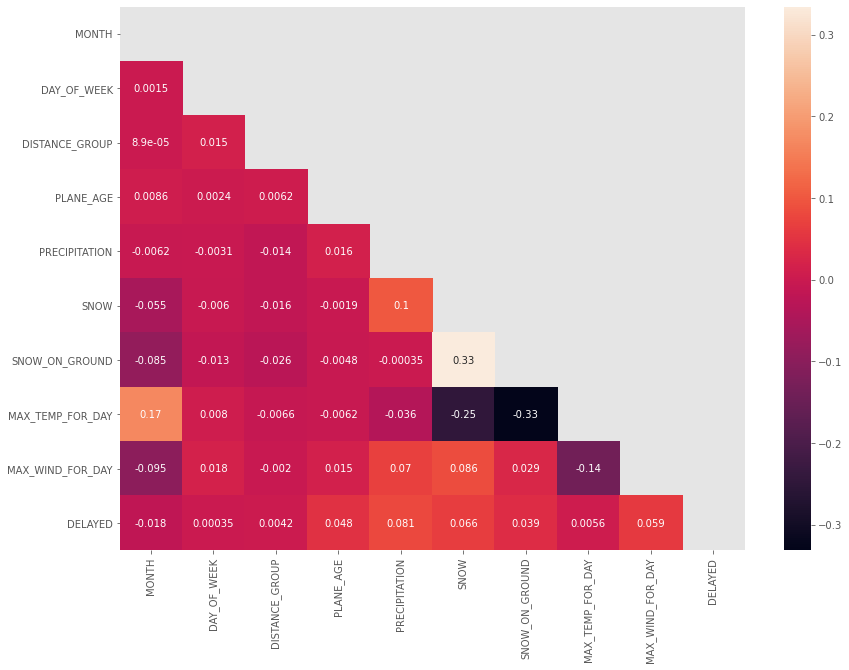

In [14]:
# Plot a heatmap with the Pearson coefficient values listed
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(data2.corr(), dtype=bool))
sns.heatmap(data2.corr(), mask=mask, annot=True);

The correlation matrix above suggests that precipitation, snow, and the maximum wind speed for the day are the three features that correlate strongly with the target variable. However, given that none of the Pearson coefficient values exceed 0.1, that isn't saying much. Also, multicollinearity doesn't seem to be a concern given this is a classification problem, and the highest correlation value in the plot is at .33 (plus or minus) - therefore, I'm not overly concerned with collinearity. 

Now that the dataset has been cleaned up, I want to take a look at the distributions of both the features and the target. This will give me an idea of whether a class imbalance exists (which I suspect there does), and how the data is distributed within that imbalance. I'll start by getting a count of the records, based on the `'MONTH'` and `'DAY_OF_WEEK'` features. Then I plot these value counts; however, I break them down further based on the target variable - labeling the bars as `'Not Delayed'` or `'Delayed'`.

In [15]:
# Break down the records by month
data2['MONTH'].value_counts().sort_index()

1     43189
2     40457
3     49824
4     49038
5     51038
6     50529
7     52122
8     52538
9     47786
10    51477
11    46880
12    48061
Name: MONTH, dtype: int64

In [16]:
# Break down the records by days of the week
data2['DAY_OF_WEEK'].value_counts().sort_index()

1    86421
2    85043
3    84471
4    84973
5    86153
6    73156
7    82722
Name: DAY_OF_WEEK, dtype: int64

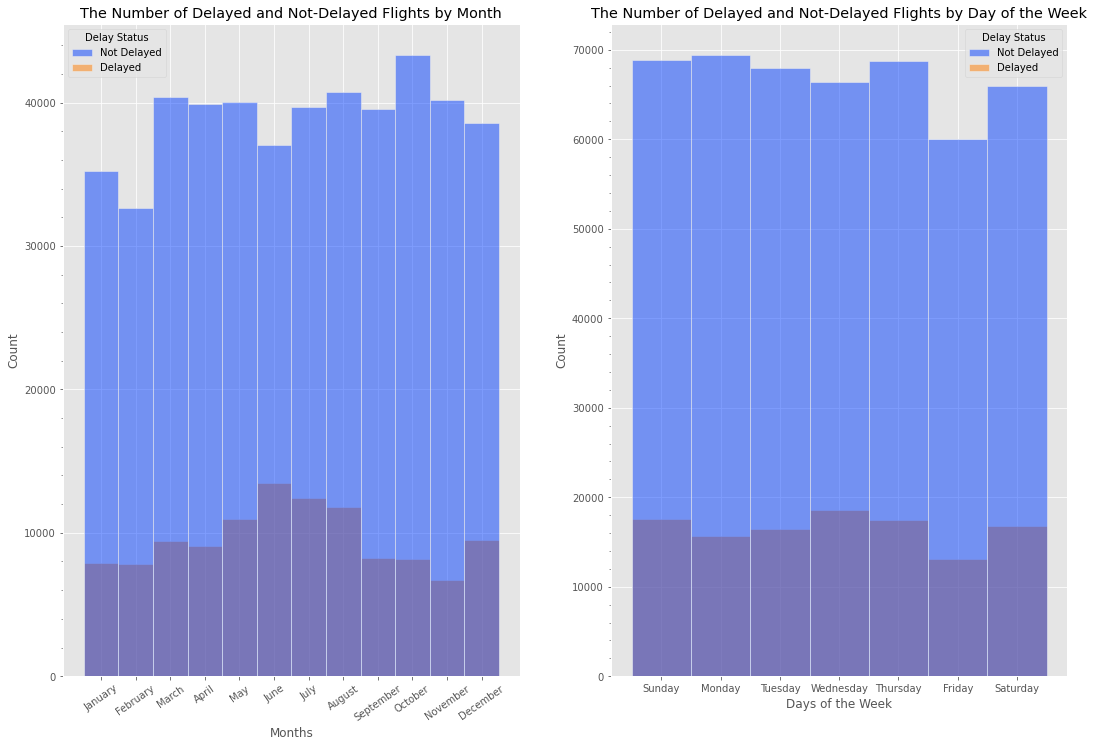

In [17]:
# Plot feature distributions

# Create month and days list objects
months = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Visualize the delay status by month
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
plot1 = sns.histplot(data2, x='MONTH', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot1.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot1.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')
ax[0].tick_params(which="both", bottom=True)

# Change x-tick labels to months (written form) and rotate the labels
old_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax[0].set_xticks(old_labels)
ax[0].set_xticklabels(months)
ax[0].tick_params(axis='x', labelrotation=35)
ax[0].set_xlabel("Months")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Month")
    
# Visualize the delay status by days of the week    
plot2 = sns.histplot(data2, x='DAY_OF_WEEK', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot2.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot2.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to days (written form)
old_labels = [1, 2, 3, 4, 5, 6, 7]
ax[1].set_xticks(old_labels)
ax[1].set_xticklabels(days)
ax[1].set_xlabel("Days of the Week")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Day of the Week");

Based on the visuals above, I see that there definitely exists a class imbalance in the dataset. In regards to the features, the first plot suggests that the summer months tend to see the highest number of delays, while the colder months seem to see less. In the second plot, the delays are highest on Wednesdays; although, the data seems to have low variation between the days of the week. 

The next few features are the `'DEP_TIME_BLK'` and the `'DISTANCE_GROUP'` columns. The first feature lists the time blocks for United Airlines flights, ranging from midnight (`'0001'`) to 11:59pm, and separated into hour blocks (besides the first block). The second feature lists all 11 distance groups, where the first group travels the shortest distance, and the eleventh group travels the farthest. 

In [18]:
# Break down the records by departure time blocks
data2['DEP_TIME_BLK'].value_counts().sort_index()

0001-0559    10189
0600-0659    42020
0700-0759    47223
0800-0859    42906
0900-0959    36314
1000-1059    35549
1100-1159    34927
1200-1259    35124
1300-1359    28503
1400-1459    33245
1500-1559    30224
1600-1659    35246
1700-1759    35880
1800-1859    36416
1900-1959    33797
2000-2059    21716
2100-2159    19542
2200-2259    12919
2300-2359    11199
Name: DEP_TIME_BLK, dtype: int64

In [19]:
# Break down the records by distance group
data2['DISTANCE_GROUP'].value_counts().sort_index()

1      29818
2      66963
3      80728
4     112096
5      65293
6      46784
7      60650
8      23843
9      16293
10     50679
11     29792
Name: DISTANCE_GROUP, dtype: int64

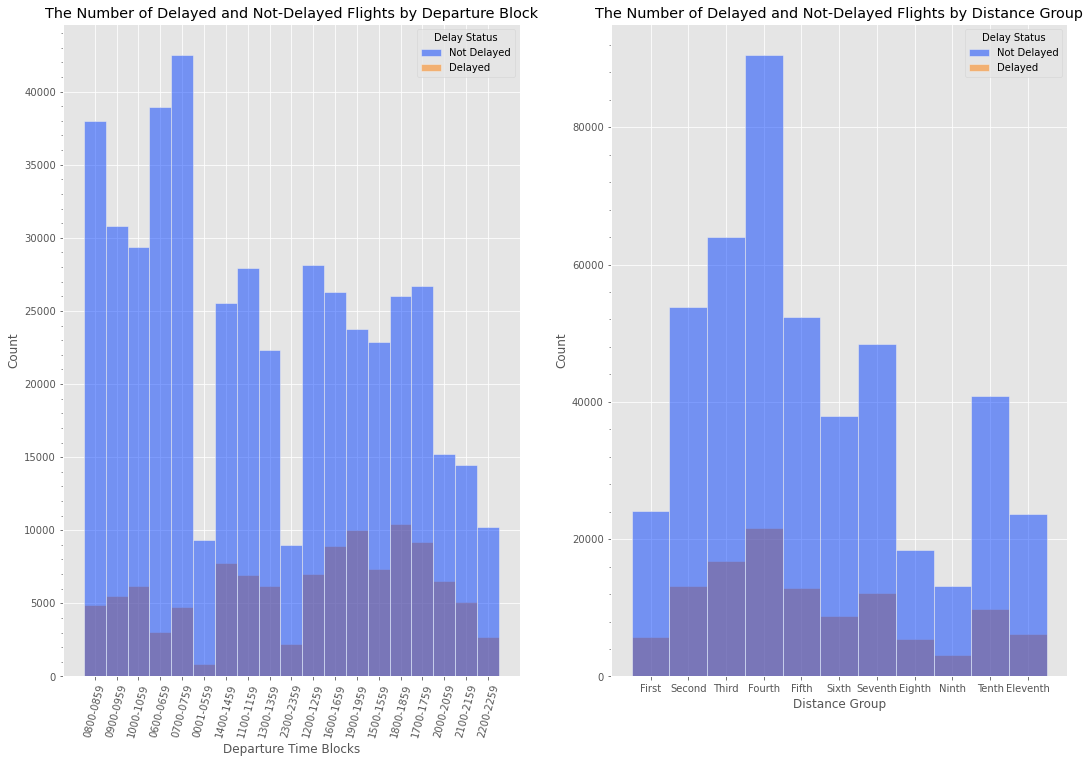

In [20]:
# Plot feature distributions
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

# Visualize the delay status by departure time block
plot3 = sns.histplot(data2, x='DEP_TIME_BLK', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot3.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot3.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')

# Rotate x-tick labels
ax[0].tick_params(axis='x', labelrotation=75)
ax[0].tick_params(which="both", bottom=True)
ax[0].set_xlabel("Departure Time Blocks")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Departure Block")
    
# Visualize the delay status by distance group  
plot4 = sns.histplot(data2, x='DISTANCE_GROUP', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot4.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot4.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to distance group (written form)
num_xlabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
str_xlabels = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth', 'Eleventh']
ax[1].set_xticks(num_xlabels)
ax[1].set_xticklabels(str_xlabels)
ax[1].set_xlabel("Distance Group")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Distance Group");

From what I see, the later time blocks (i.e., starting at 4pm to about 8pm) face the most delays. However, in the second visual, the third and fourth distance groups experience more delays, which is far less than those in farther distance groups. 

To be able to plot the rest of the features, I utilize both kdeplots and boxplots because the data within those columns are numerical and continuous, in nature. I see that all six graphs contain outliers that affect the distribution one way or another. 

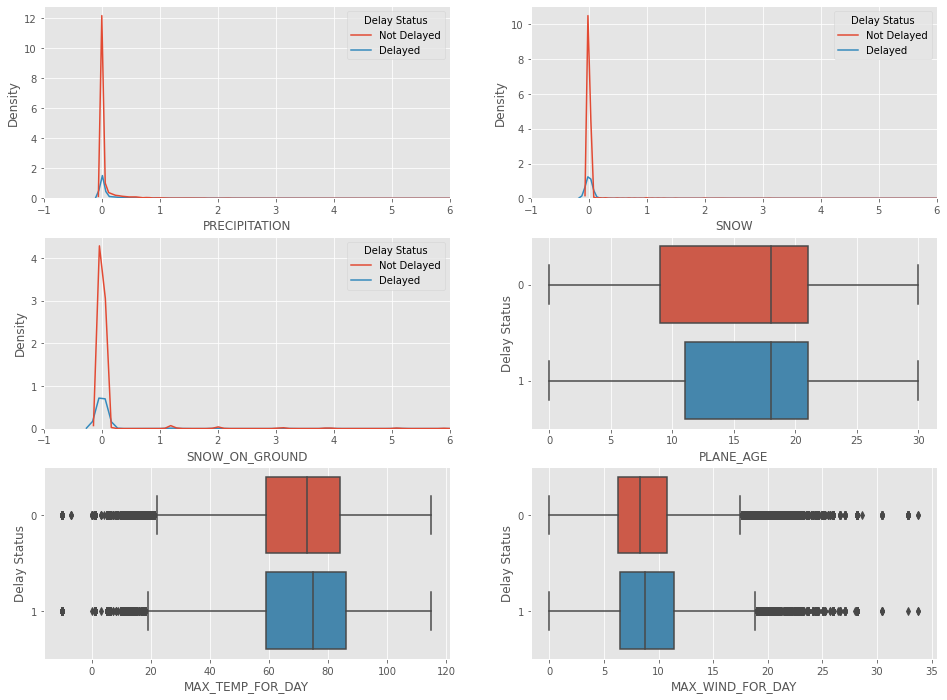

In [21]:
# Plot the remaining continuous variables with the delay status 
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
kde1 = sns.kdeplot(data=data2, x="PRECIPITATION", hue="DELAYED", ax=ax[0,0])
kde2 = sns.kdeplot(data=data2, x="SNOW", hue="DELAYED", ax=ax[0,1])
kde3 = sns.kdeplot(data=data2, x="SNOW_ON_GROUND", hue="DELAYED", ax=ax[1,0])
box1 = sns.boxplot(data=data2, x="PLANE_AGE", y="DELAYED", orient='h', ax=ax[1,1])
box2 = sns.boxplot(data=data2, x="MAX_TEMP_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,0])
box3 = sns.boxplot(data=data2, x="MAX_WIND_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,1]);

kdeplots = [kde1, kde2, kde3]
for plot in kdeplots:
    new_title = 'Delay Status'
    plot.legend_.set_title(new_title)
    new_labels = ['Not Delayed', 'Delayed']
    for t, l in zip(plot.legend_.texts, new_labels):
        t.set_text(l)
    plot.set_xlim(-1, 6) 

boxplots = [box1, box2, box3]
for boxplot in boxplots:
    boxplot.set(ylabel='Delay Status')

It's time to examine the target, and confirm the class imbalance I mentioned earlier. First, I plot my target as a bar plot, then as a pie chart. I plot both to show both the count and weight of each label in the dataset. 

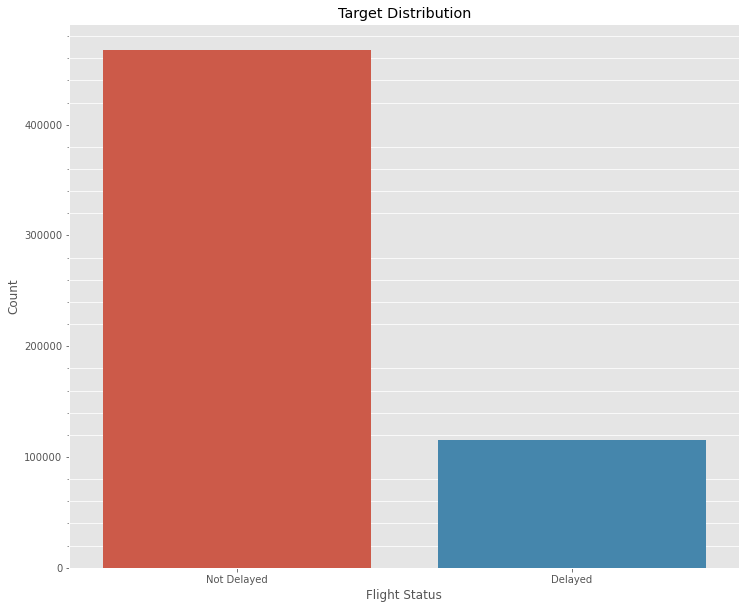

In [22]:
# Visualize the class (target) distribution
fig, ax = plt.subplots(figsize=(12,10))

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax.yaxis.set_minor_locator(minor_locator)
ax.set_axisbelow(True)
plt.grid(which='both')

# Plot the target 
sns.countplot(data=data2, x='DELAYED', orient='v')
ax.set_title('Target Distribution')

# Change x-tick labels 
old_labels = [0, 1]
new_xlabels = ['Not Delayed', 'Delayed']
ax.set_xticks(old_labels)
ax.set_xticklabels(new_xlabels)

ax.set_xlabel("Flight Status")
ax.set_ylabel("Count");

The bar plot above confirms my earlier speculation of a class imbalance - showing over 460,000 flights as `'Not Delayed'` and a little under 120,000 as `'Delayed'` flights. The pie plot below reinforces this observation, but with weights. I see that out of 600,000 flights, about 20% are delayed - this is quite high considering the high amount of flights taken in a year through United. 

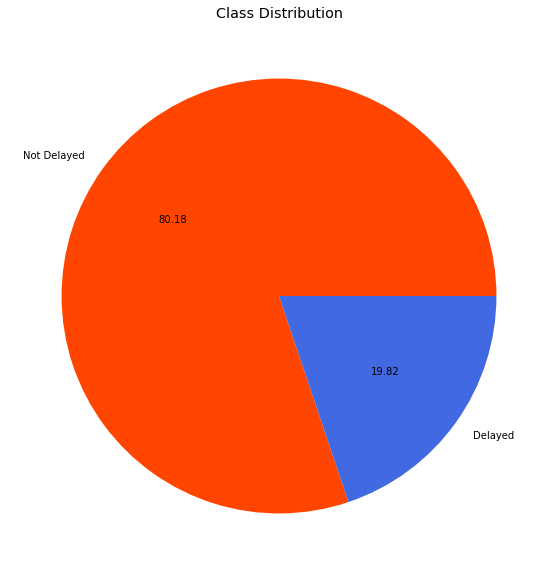

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
data2['DELAYED'].value_counts().plot.pie(autopct='%.2f', title='Class Distribution', 
                                        labels=['Not Delayed', 'Delayed'], colors=['orangered', 'royalblue'])
ax.yaxis.set_visible(False);

I've gained some insight into how my data is structured and distributed; therefore, now it is time to begin modeling and building my algorithm. 

### Further Preprocessing:
In order to properly model my dataframe, I need to encode the categorical features into quanitative data. I use pandas's `get_dummies` function to encode my five categorical columns into numerical form, then list the first 5 records to confirm the transformation. 

In [24]:
cols_to_encode = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'DEPARTING_AIRPORT']
data2_enc = pd.get_dummies(data2, columns=cols_to_encode)

In [25]:
data2_enc.head()

,PLANE_AGE,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED,MONTH_1,MONTH_2,MONTH_3,...,DEPARTING_AIRPORT_Standiford Field,DEPARTING_AIRPORT_Stapleton International,DEPARTING_AIRPORT_Syracuse Hancock International,DEPARTING_AIRPORT_Tampa International,DEPARTING_AIRPORT_Theodore Francis Green State,DEPARTING_AIRPORT_Truax Field,DEPARTING_AIRPORT_Tucson International,DEPARTING_AIRPORT_Tulsa International,DEPARTING_AIRPORT_Washington Dulles International,DEPARTING_AIRPORT_Will Rogers World
21,6,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
22,22,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
23,3,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24,19,0.0,0.0,0.0,65.0,2.91,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25,4,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The dataframe above will serve as the final product before I split the dataset into a training, testing and validation set. First, I split the data 75/25, with 25% of the dataset reserved for the test set. Next, I split the test data even further (by half, actually) into a smaller test set and a newly-formed validation set. I check the shape multiple times as a sanity check.

In [26]:
y = data2_enc['DELAYED']
X = data2_enc.drop('DELAYED', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=seed)
X_train.shape

(437204, 139)

In [27]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=seed)
X_val.shape

(72868, 139)

Given the initial class imbalance, I need to apply a sampling technique - specifically, undersampling - to reduce the majority class (`'Not Delayed'`) in my data to an even ratio with the minority class (`'Delayed'`). I plot the pie chart and class weights once again, but this time expecting an even ratio (as shown below).

In [28]:
rus = RandomUnderSampler(sampling_strategy=1, random_state=seed) # Numerical value
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

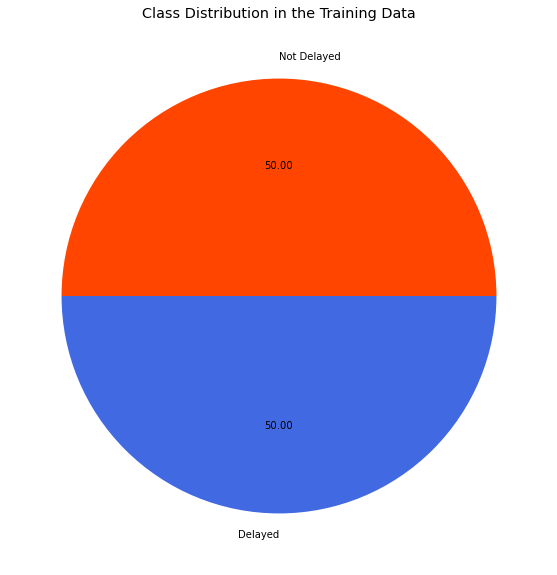

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))
y_train_res.value_counts().plot.pie(autopct='%.2f', title='Class Distribution in the Training Data', 
                                        labels=['Not Delayed', 'Delayed'], colors=['orangered', 'royalblue'])
ax.yaxis.set_visible(False);

In [30]:
X_train_res.shape

(173382, 139)

I print the shape of the training data once more, to confirm that the dataframe's shape remains intact. 

## Modeling

Now it is time to begin modeling! I will begin my process by cross-validating 4 different classifiers, and evaluating them based on precision, recall, and f1 scores. As a reminder, my main focus is to improve precision, and consequently, the amount of false positives (i.e. predicting a flight to be delayed when it is actually on time/not delayed). However, I will still track the recall score (or the amount of false negatives), and the f1 score, which is the harmonic mean of precision and recall. The baseline model with the best trio of average metric scores will be selected to undergo hyperparameter tuning and further testing.

### Baseline Modeling:

I begin by using `imblearn`'s `make_pipeline` function in order to pass a sampler along with a scaler and classifier into my pipeline(s). I cross-validate these pipelines in 3 folds, then take the average of each score and print them for each classifier. 

In [31]:
classifier_names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
classifiers = [DecisionTreeClassifier(random_state=seed), RandomForestClassifier(random_state=seed), 
               AdaBoostClassifier(random_state=seed), GradientBoostingClassifier(random_state=seed)]

for name, classifier in zip(classifier_names, classifiers):
    pipe = make_pipeline((RandomUnderSampler(sampling_strategy=1, random_state=seed)),
                          (MinMaxScaler()),
                          (classifier))
    score = cross_validate(pipe, X, y, cv=3, scoring=['precision', 'recall', 'f1'])
    model_scores = []
    keys = ['test_precision', 'test_recall', 'test_f1']
    for key in keys:
        model_scores.append(np.mean(score[key]))
    print("Test precision, recall and F1 scores for {}: {}\n".format(name, model_scores))

Test precision, recall and F1 scores for Decision Tree: [0.2036319709613683, 0.4754932502596054, 0.2811930503015776]

Test precision, recall and F1 scores for Random Forest: [0.24767570247321194, 0.5141658013153341, 0.3253398416456819]

Test precision, recall and F1 scores for AdaBoost: [0.24669017438739085, 0.5515057113187954, 0.3356349773479644]

Test precision, recall and F1 scores for Gradient Boost: [0.24535113500312686, 0.5704395984769817, 0.3380784192923488]



Based on the scores above, it seems that GradientBoosting Classifiers is the best algorithm! 

### Tuning Best Baseline Models:

In [65]:
scorers = {'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

gbt_pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                           ('pca', PCA(random_state=seed)),
                           ('classifier', GradientBoostingClassifier(random_state=seed))])

gbt_param_grid = {'pca__n_components': [5, 10, 25, 50],
                  'classifier__n_estimators': [50, 75, 100],
                  'classifier__learning_rate': [1, 0.1, 0.01]}

gbt_gridsearch = GridSearchCV(gbt_pipe, gbt_param_grid, scoring=scorers,
                              refit='precision_score', verbose=3, cv=3)

In [66]:
gbt_gridsearch.fit(X_train_res, y_train_res)

grid_dict = {0: 'GradientBoosting Classifier'} 
for i, model in enumerate(grids):
    print('{} Validation Metrics: {}'.format(grid_dict[i], model.best_score_(X_val, y_val)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.509, precision_score=0.542, recall_score=0.480, total=  18.8s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s


[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.520, precision_score=0.545, recall_score=0.497, total=  18.9s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.7s remaining:    0.0s


[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.522, precision_score=0.548, recall_score=0.498, total=  18.8s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10, f1_score=0.530, precision_score=0.559, recall_score=0.504, total=  35.3s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10, f1_score=0.535, precision_score=0.562, recall_score=0.510, total=  33.3s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10, f1_score=0.541, precision_score=0.565, recall_score=0.519, total=  35.2s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=25 
[CV]  classifier__learnin

[CV]  classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.517, precision_score=0.535, recall_score=0.501, total=  17.3s
[CV] classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5 
[CV]  classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.523, precision_score=0.543, recall_score=0.505, total=  17.1s
[CV] classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5 
[CV]  classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.517, precision_score=0.547, recall_score=0.490, total=  19.0s
[CV] classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=10, f1_score=0.530, precision_score=0.552, recall_score=0.510, total=  34.7s
[CV] classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classif

[CV]  classifier__learning_rate=0.1, classifier__n_estimators=100, pca__n_components=50, f1_score=0.639, precision_score=0.601, recall_score=0.683, total= 5.9min
[CV] classifier__learning_rate=0.1, classifier__n_estimators=100, pca__n_components=50 
[CV]  classifier__learning_rate=0.1, classifier__n_estimators=100, pca__n_components=50, f1_score=0.636, precision_score=0.605, recall_score=0.671, total= 5.9min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5, f1_score=0.502, precision_score=0.530, recall_score=0.476, total=  16.7s
[CV] classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5, f1_score=0.497, precision_score=0.528, recall_score=0.469, total=  18.5s
[CV] classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5 
[CV] 

[CV]  classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=25, f1_score=0.579, precision_score=0.562, recall_score=0.596, total= 3.9min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=25 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=25, f1_score=0.538, precision_score=0.583, recall_score=0.500, total= 3.9min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=50 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=50, f1_score=0.637, precision_score=0.578, recall_score=0.711, total= 7.7min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=50 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=50, f1_score=0.652, precision_score=0.571, recall_score=0.761, total= 7.7min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_compone

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 225.5min finished


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
grid_dict = {0: 'GradientBoosting Classifier'} 
for i, model in enumerate(grids):
    print('{} Validation Metrics: {}'.format(grid_dict[i], model.best_score_(X_val, y_val)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

In [ ]:
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

In [ ]:
plot_confusion_matrix(svm_grid_search, X_test, y_test)

### Deep Learning:

In [ ]:
# Create a dense baseline neural network
neural_network = Sequential()
neural_network.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(173382, )))
neural_network.add(Dense(8, activation='relu'))
neural_network.add(Dense(1, activation='sigmoid'))

# Compile the baseline model
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['precision'])

# List a summary of the baseline model
neural_network.summary()

In [ ]:
# Fit the baseline model
baseline = neural_network.fit(X_train_res, y_train_res, epochs=32, batch_size=256,
                                      validation_data=(X_val, y_val))

In [ ]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{neural_network.evaluate(X_train_res, y_train_res)}')
print('\n')
print(f'Validation data results:\n{neural_network.evaluate(X_val, y_val)}')

# Generate predictions and "round" the values
y_hat_val = regularized_model.predict(X_val)
y_hat_val[y_hat_val > 0.5] = 1
y_hat_val[y_hat_val < 0.5] = 0

# Plot a confusion matrix of the validation data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, y_hat_val), annot=True,
           fmt='.3g', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Use the MinMaxScaler function to scale the data
cols = X_train_res.columns

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns = cols)
X_val = pd.DataFrame(X_val_scaled, columns = cols)
X_test = pd.DataFrame(X_test_scaled, columns = cols)

# Check & reconfirm the training data's shape
X_train.shape

In [ ]:
# Create a baseline model - a Decision Tree
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=seed, class_weight='balanced')
tree_clf.fit(X_train, y_train_res)

# Predict estimates for both training & test sets
y_train_hat = tree_clf.predict(X_train)
y_val_hat = tree_clf.predict(X_val)

# Print the accuracy and precision scores for both sets of data
print("Training Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_train_res, y_train_hat) * 100))
print("Validation Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_val, y_val_hat) * 100))
print('')
print("Training Precision for Decision Tree Classifier: {:.4}%".format(precision_score(y_train_res, y_train_hat) * 100))
print("Validation Precision for Decision Tree Classifier: {:.4}%".format(precision_score(y_val, y_val_hat) * 100))

In [ ]:
# Print the classification report
print(f'Decision Tree: \n{classification_report(y_val, y_val_hat)}')

In [ ]:
# Plot the confusion matrix 
cm = confusion_matrix(y_val, y_val_hat, labels=tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=tree_clf.classes_)
disp.plot()
plt.grid(False)
plt.show();

In [ ]:
# Generate a sorted dictionary listing the feature importances
feature_rankings = {}
for fi, feature in sorted(zip(tree_clf.feature_importances_, X_train.columns), reverse=True):
    feature_rankings[feature] = fi
print(feature_rankings)

In [ ]:
# Visualize the feature importances
importances = tree_clf.feature_importances_
important_features = pd.Series(importances, index=X_train.columns)


fig, ax = plt.subplots(figsize=(10, 8))
important_features.nlargest(17).plot(kind='barh', color='crimson')
ax.set_title("Feature Importances")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
fig.tight_layout()

## Evaluation

## Conclusion

## Limitations/Further Work

In [ ]:
# List (and sort) the value counts of each departure time block
#value_counts = data2['DEP_TIME_BLK'].value_counts().sort_index()

# Create a dictionary that represents each unique time block with a number
#block_number = {value: i for i, value in enumerate(value_counts.index)}

# Replace each time block with its corresponding unique value
#data2["DEP_TIME_BLK"] = data2["DEP_TIME_BLK"].map(block_number)
#data2.head()

In [ ]:
# List (and sort) the value counts of each departing airport
#value_counts_airports = data2['DEPARTING_AIRPORT'].value_counts().sort_index()

# Create a dictionary that associates each unique airport with a unique number
#airport_number = {value: i for i, value in enumerate(value_counts_airports.index)}

# Replace each departing airport with its corresponding unique value
#data2['DEPARTING_AIRPORT'] = data2['DEPARTING_AIRPORT'].map(airport_number)
#data2.head()

In [ ]:
#pca = PCA(n_components=50, random_state=seed)
#pca_train = pca.fit_transform(X_train)
#pca_val = pca.transform(X_val)
#pca_test = pca.transform(X_test)
#print(np.sum(pca.explained_variance_ratio_)*100)

In [ ]:
#X_train = pd.DataFrame(pca_train)
#X_val = pd.DataFrame(pca_val)
#X_test = pd.DataFrame(pca_test)
#X_train.shape

In [60]:
scorers = {'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

ada_pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                           ('pca', PCA(random_state=seed)),
                           ('classifier', AdaBoostClassifier(random_state=seed))])

ada_param_grid = {'pca__n_components': [5, 10, 25, 50],
                  'classifier__n_estimators': [50, 75, 100],
                  'classifier__learning_rate': [1, 0.1, 0.01]}

ada_gridsearch = GridSearchCV(ada_pipe, ada_param_grid, scoring=scorers,
                              refit='precision_score', verbose=3, cv=3)

In [ ]:
ada_gridsearch.fit(X_train_res, y_train_res)

grid_dict = {0: 'AdaBoost Classifier'} 
for i, model in enumerate(grids):
    print('{} Validation Metrics: {}'.format(grid_dict[i], model.best_score_(X_val, y_val)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

In [ ]:
grids = [ada_gridsearch, gbt_gridsearch]
for grid in grids:
    grid.fit(X_train_res, y_train_res)

grid_dict = {0: 'AdaBoost Classifier', 1: 'GradientBoosting Classifier'}
for i, model in enumerate(grids):
    print('{} Validation Metrics: {}'.format(grid_dict[i], model.best_score_(X_val, y_val)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

## Sources
Link to original dataset: 
https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations/data?select=full_data_flightdelay.csv

Wall Street Journal annual airlines ranking report:
https://www.wsj.com/lifestyle/travel/best-airlines-us-2023-36e9ea20

